In [1]:
import pandas as pd
import numpy as np

lan_df = pd.read_csv("/Users/renegonzalez/Desktop/DNN LoL/lan_dataset.csv")
na_df = pd.read_csv("/Users/renegonzalez/Desktop/DNN LoL/na_dataset.csv")
lan_df.head()


,Blue Mastery 1,Blue Mastery 2,Blue Mastery 3,Blue Mastery 4,Blue Mastery 5,Blue Masteries Avg,Blue Masteries Median,Blue Masteries Kurtorsis,Blue Masteries Skewness,Blue Masteries Std,...,Red Winrate 3,Red Winrate 4,Red Winrate 5,Red Winrates Avg,Red Winrates Median,Red Winrates Kurtorsis,Red Winrates Skewness,Red Winrates Std,Red Winrates Variance,Blue Won
0,302361,32548,137831,42344,2594552,621927.2,137831.0,4.804286,2.183943,991060.524461,...,0.485714,0.333333,0.588384,0.511934,0.552239,1.755027,-1.441162,0.097786,0.009562,0
1,244724,55894,166393,151398,17928,127267.4,151398.0,-1.336965,0.013165,81189.183929,...,0.551136,0.641509,0.500000,0.589079,0.551136,-0.950929,0.766032,0.077926,0.006073,0
2,1370461,165699,328554,11922,64623,388251.8,165699.0,4.066366,1.991324,502829.634615,...,0.631579,0.535714,0.529412,0.580125,0.535714,-0.171439,0.832254,0.092372,0.008533,0
3,859153,8207,152833,30736,94462,229078.2,94462.0,4.494974,2.098720,319077.677286,...,0.142857,0.515789,0.523632,0.336456,0.500000,-2.252575,-0.789161,0.221190,0.048925,1
4,295938,326564,1812645,64742,83541,516686.0,295938.0,4.480466,2.090117,656696.848512,...,0.565284,0.600000,0.416667,0.547907,0.565284,-1.091492,0.001576,0.094206,0.008875,1


Now we read our processed datasets, explanations on how to create the dataset can be found in the Readme.

1. We are gonna use the datasets from LAN server (12458 unique ranked matches) to train our algorithm
2. We are gonna divide the training dataset into training and validation. Having the validation 20% of the training dataset.
3. Lastly we are gonna use the datasets from NA server (4552 unique ranked matches) to test our algorithm.

Notice that the CSV file contains on each line the 44 features of the match and at the end 1 if the blue team (First team on the sample) won or 0 otherwise.


In [2]:
lan_dataset = lan_df.to_numpy()
na_dataset = na_df.to_numpy()

np.random.shuffle(lan_dataset)
np.random.shuffle(na_dataset)

X = lan_dataset[:, 0:44]
Y = lan_dataset[:, 44]

print(X.shape)
print(Y.shape)

x_train = lan_dataset[:, 0:44]
y_train = lan_dataset[:, 44]

x_test = na_dataset[:, 0:44]
y_test = na_dataset[:, 44]


print(f"x_train size: {len(x_train)}")
print(f"y_train size: {len(y_train)}")


print(f"x_test size: {len(x_test)}")
print(f"y_test size: {len(y_test)}")


(12458, 44)
(12458,)
x_train size: 12458
y_train size: 12458
x_test size: 4552
y_test size: 4552


Now we create the model architecture using keras and following the structure described in the paper:

• Alternating dropout, normalization, and dense layers for a total of 15 layers (5 dropout, 5 normalization, and 5 dense
layers). Each group of alternating layers had 160, 128, 64, 32, and 16 neurons, in that order.

- Each dropout layer had a dropout rate of 0.69%.
- Each normalization layer utilized batch normalization.
- Each dense layer used Exponential Linear Unit (ELU) activation, He initialization.
- A 1 × 1 dense layer with Sigmoid activation

Finally we compile using basic parameters for classification problems


In [3]:
from keras.initializers import HeNormal
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

# Create the model architecture lol
initializer = HeNormal()
model = Sequential(
    [
        Dropout(0.69, input_dim=44),
        BatchNormalization(),
        Dense(160, activation="elu", kernel_initializer=initializer),
        Dropout(0.69),
        BatchNormalization(),
        Dense(128, activation="elu", kernel_initializer=initializer),
        Dropout(0.69),
        BatchNormalization(),
        Dense(64, activation="elu", kernel_initializer=initializer),
        Dropout(0.69),
        BatchNormalization(),
        Dense(32, activation="elu", kernel_initializer=initializer),
        Dropout(0.69),
        BatchNormalization(),
        Dense(16, activation="elu", kernel_initializer=initializer),
        Dense(1, activation="sigmoid"),
    ]
)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


2022-02-09 17:54:17.194714: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now we train the model with our train dataset and our validation dataset.

**Note:**
After multiple tests I found that 50 epochs and a batch_size of 200 are the best parameters, feel free to try change them in your code.


In [4]:
# fit the model
history = model.fit(
    x_train, y_train, validation_data=(x_test, y_test), epochs=49, batch_size=256
)


Epoch 1/49
49/49 [==============================] - 6s 24ms/step - loss: 0.8449 - accuracy: 0.4950 - val_loss: 0.6365 - val_accuracy: 0.6151
Epoch 2/49
49/49 [==============================] - 1s 16ms/step - loss: 0.7481 - accuracy: 0.5063 - val_loss: 0.6570 - val_accuracy: 0.5200
Epoch 3/49
49/49 [==============================] - 1s 17ms/step - loss: 0.7144 - accuracy: 0.5235 - val_loss: 0.6646 - val_accuracy: 0.5112
Epoch 4/49
49/49 [==============================] - 1s 17ms/step - loss: 0.7080 - accuracy: 0.5194 - val_loss: 0.6617 - val_accuracy: 0.5174
Epoch 5/49
49/49 [==============================] - 1s 16ms/step - loss: 0.6972 - accuracy: 0.5293 - val_loss: 0.6544 - val_accuracy: 0.5857
Epoch 6/49
49/49 [==============================] - 1s 17ms/step - loss: 0.6940 - accuracy: 0.5376 - val_loss: 0.6405 - val_accuracy: 0.7065
Epoch 7/49
49/49 [==============================] - 1s 18ms/step - loss: 0.6905 - accuracy: 0.5415 - val_loss: 0.6235 - val_accuracy: 0.7819
Epoch 8/49
49

And finally we evaluate our model using the training dataset, validation dataset and testing dataset.


In [5]:
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)

print("Train Accuracy: {:.2f}%".format(train_acc * 100))
print("Test Accuracy: {:.2f}%".format(test_acc * 100))


Train Accuracy: 83.05%
Test Accuracy: 82.23%


Now we plot the history of loss using matplotlib


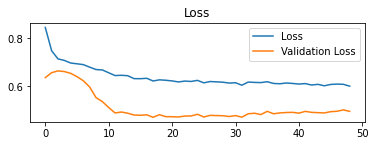

In [6]:
from matplotlib import pyplot

# plot loss during training
pyplot.subplot(211)
pyplot.title("Loss")
pyplot.plot(history.history["loss"], label="Loss")
pyplot.plot(history.history["val_loss"], label="Validation Loss")
pyplot.legend()
pyplot.show()


Now we plot the history of accuracy using matplotlib


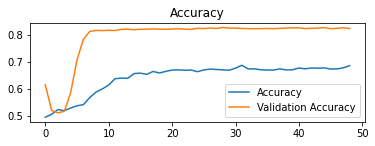

In [7]:
# plot accuracy during training
pyplot.subplot(212)
pyplot.title("Accuracy")
pyplot.plot(history.history["accuracy"], label="Accuracy")
pyplot.plot(history.history["val_accuracy"], label="Validation Accuracy")
pyplot.legend()
pyplot.show()


### Results

Even though we trained our model with matches from LAN server we can see that it performed really well using the matches from a different server. Having an insanely high 82% accuracy.
